In [1]:
from fact.io import read_h5py
from ctapipe.coordinates import CameraFrame
from astropy.coordinates import AltAz, SkyCoord, EarthLocation, SkyOffsetFrame
from astropy.coordinates.erfa_astrom import ErfaAstromInterpolator, erfa_astrom
from astropy.time import Time
import astropy.units as u
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


%matplotlib notebook

In [2]:
# faster coordinate trafos
erfa_astrom.set(ErfaAstromInterpolator(10 * u.min))

<ScienceState erfa_astrom: <astropy.coordinates.erfa_astrom.ErfaAstromInterpolator object at 0x7fc7e89c2710>>

In [3]:
def calc_theta_off(source_coord: SkyCoord, reco_coord: SkyCoord, pointing_coord: SkyCoord, n_off=5):
    fov_frame = SkyOffsetFrame(origin=pointing_coord)
    source_fov = source_coord.transform_to(fov_frame)
    reco_fov = reco_coord.transform_to(fov_frame)
    
    r = source_coord.separation(pointing_coord)
    phi0 = np.arctan2(source_fov.lat, source_fov.lon).to_value(u.rad)
    
    theta_offs = []
    for off in range(1, n_off + 1):
        
        off_pos = SkyCoord(
            lon=r * np.sin(phi0 + 2 * np.pi * off / (n_off + 1)),
            lat=r * np.cos(phi0 + 2 * np.pi * off / (n_off + 1)),
            frame=fov_frame,
        )
        
        theta_offs.append(off_pos.separation(reco_fov))
        
    return reco_coord.separation(source_coord), np.concatenate(theta_offs)

In [4]:
location = EarthLocation.of_site('Roque de los Muchachos')

sources = {
    'Crab Nebula': {
        'runs': [2767, 2768, 2769, 2770,  2771],
    },
    'Mrk 421': {
        'runs': [2113, 2114, 2115, 2116, 2117, 2130, 2131, 2132, 2133]
    }
}

In [6]:
# read data, apply transforms, calc run duration
for name, source in sources.items():
    print('Reading data for', name)
    
    events = []
    durations = []
    for run in source['runs']:
        events.append(read_h5py(
            f'/scratch/mnoethe/lst_mono/build_150/dl2_v0.6.1_v05_LST-1.Run{run:05d}.h5',
            key='events',
        ))
        durations.append(events[-1]['dragon_time'].max() - events[-1]['dragon_time'].min())
    
    
    df = pd.concat(events)
    df.set_index(['obs_id', 'event_id'], inplace=True)
    
    
    # calc ontime / duration
    diff = df['dragon_time'].diff()
    mean_diff = diff[diff < 1].mean()
    source['ontime'] = (mean_diff * len(df) * u.s).to(u.hour)    
    source['duration'] = (sum(durations) * u.s).to(u.hour)
    print(f'Ontime: {source["ontime"]:.2f}, Duration: {source["duration"]:.2f}')
    
    print(f'Total     #Events: {len(df)}')
    df = df.dropna(axis=0, subset=['source_x_prediction', 'source_y_prediction', 'gammaness'])
    print(f'Predicted #Events: {len(df)}')
    
    obstime = Time(df.dragon_time, format='unix')
    altaz = AltAz(obstime=obstime, location=location)
    
    pointing = SkyCoord(
        alt=u.Quantity(df.alt_tel.values, u.rad, copy=False),
        az=u.Quantity(df.az_tel.values, u.rad, copy=False),
        frame=altaz,
    )
    
    prediction_cam = SkyCoord(
        x=u.Quantity(df.source_x_prediction.values, u.m, copy=False),
        y=u.Quantity(df.source_y_prediction.values, u.m, copy=False),
        frame=CameraFrame(telescope_pointing=pointing, location=location, obstime=obstime, focal_length=28 * u.m)
    )
    
    prediction_icrs = prediction_cam.transform_to('icrs')
    pointing_icrs = pointing.transform_to('icrs')
    
    
    source['coord'] = SkyCoord.from_name(name)
    source['events'] = df
    source['pointing_coord'] = pointing_icrs
    source['predicted_coord'] = prediction_icrs
    
    
    # add as columns to df for convenience
    df['source_ra_prediction'] = prediction_icrs.ra.deg
    df['source_dec_prediction'] = prediction_icrs.dec.deg
    df['pointing_ra'] = pointing_icrs.ra.deg
    df['pointing_dec'] = pointing_icrs.dec.deg
    
    print(name, 'done\n')

Reading data for Crab Nebula
Ontime: 1.34 h, Duration: 1.41 h
Total     #Events: 5330744
Predicted #Events: 5330740
Crab Nebula done

Reading data for Mrk 421
Ontime: 2.22 h, Duration: 2.23 h
Total     #Events: 7274690
Predicted #Events: 7274341
Mrk 421 done



<IPython.core.display.Javascript object>


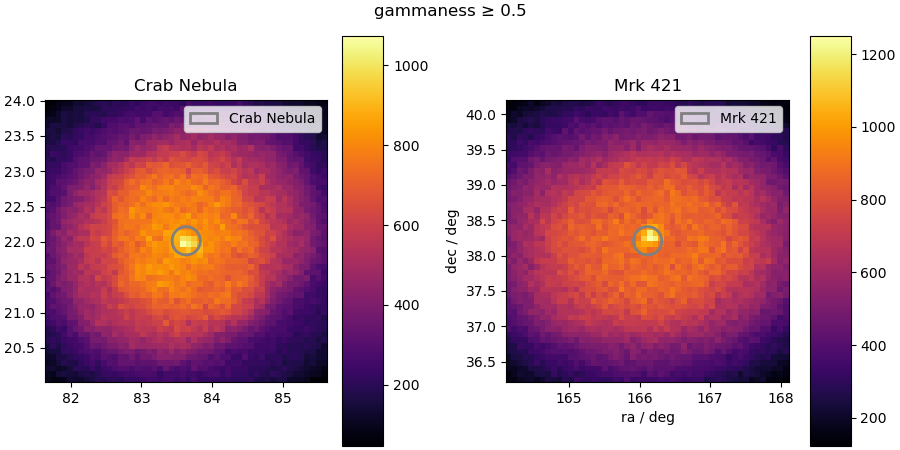

In [8]:
gammaness_cut = 0.5


fig, axs =  plt.subplots(1, len(sources), constrained_layout=True, figsize=(9, 4.5))
axs = np.array([axs]).ravel()


for ax, (name, source) in zip(axs, sources.items()):
    
    
    ra = source['coord'].ra.deg
    dec = source['coord'].dec.deg
    df = source['events'].query(f'gammaness >= {gammaness_cut}')
    
    _, _, _, hist = ax.hist2d(
        df.source_ra_prediction, df.source_dec_prediction,
        bins=50, 
        range=[[ra - 2, ra + 2], [dec - 2, dec + 2]],
        cmap='inferno'
    )
    ax.set_title(name)
    ax.set_aspect(1)

    circ = plt.Circle(xy=(ra, dec), radius=np.sqrt(0.04), fill=False, edgecolor='gray', lw=2)
    ax.add_patch(circ)
    
    ax.legend((circ,), (name, ))
    fig.colorbar(hist, ax=ax)
    
ax.set_xlabel('ra / deg')
ax.set_ylabel('dec / deg')
fig.suptitle(f'gammaness ≥ {gammaness_cut}')

None

In [ ]:
from pyirf.statistics import li_ma_significance

theta_cut = 0.15 * u.deg
gammaness_cut = 0.85

n_off_positions = 5
source = sources['Mrk 421']

fig, axs = plt.subplots(1, 2, figsize=(9, 4.5), constrained_layout=True)

for ax, (name, source) in zip(axs, sources.items()):

    mask = source['events']['gammaness'] >= gammaness_cut
    
    theta, theta_off = calc_theta_off(
        source_coord=source['coord'],
        reco_coord=source['predicted_coord'][mask],
        pointing_coord=source['pointing_coord'][mask],
        n_off=5,
    )


    n_on = np.count_nonzero(theta <= theta_cut)
    n_off = np.count_nonzero(theta_off <= theta_cut)
    alpha = 1 / n_off_positions
    n_excess = n_on - alpha * n_off
    n_excess_unc = np.sqrt(n_on + alpha**2 * n_off)
    sig = li_ma_significance(n_on, n_off, alpha)

    # make sure theta cut is on bin edge
    bins = np.arange(0, 0.3, theta_cut.to_value(u.deg)**2 / 3)
    ax.hist(
        theta_off.deg**2,
        bins=bins,
        color='lightgray',
        weights=np.full(len(theta_off), 1/n_off_positions)

    )

    ax.hist(
        theta.deg**2,
        bins=bins,
        histtype='step'
    )

    ax.axvline(theta_cut.to_value(u.deg)**2, color='k')
    ax.margins(0, None)
    
    txt = rf'''$N_\mathrm{{On}} = {n_on}, N_\mathrm{{Off}} = {n_off}, \alpha = {1 / n_off_positions}$
    $N_\mathrm{{excess}} = {n_excess:.1f} \pm {n_excess_unc:.1f}$
    $S_\mathrm{{Li  Ma}} = {sig:.1f} \sigma$ in $T = {source['duration'].to_value(u.hour):.2f}\,\mathrm{{h}}$
    '''

    ax.text(0.5, 0.95, txt, transform=ax.transAxes, va='top', ha='center')
    ax.set_title(name)
    ax.set_xlabel('θ² / deg²')